<div align='center'>
    
## Image Processing

###  SIFT

#### 28 March 2022
    Version 0.85
    
</div>

### 5.1 About SIFT
The SIFT (Scale-Invariant Feature Transform) has been around since the early 2000’s. The method was proposed by computer scientist David G. Lowe, but drew on ideas from a number of other people, notably from scale-space (T. Lindenberg, J. Koenderink), together with work on gradient histograms pioneered by Bill Triggs. SIFT is not a transform in the usual sense of image transforms introduced in Chapter 3. It is, instead, a methodology for identifying stable points in an image (keypoints), then creating “fingerprints” around those points known as descriptors. The descriptors are typically a few hundred bytes in length, and describe the gra- dient field (see Chapter 4) around the keypoints. The scale of region over which the fingerprint is generated is assigned through a process of scale estimation.

SIFT is also not a segmentation technique, but a combination of a few algorithms that provide a means of making feature vectors that are invariant to rotation and scale changes between a template (so, an example of an object you are looking for, taking the form of an image) and a second image.  The aim is either to i) verify the presence of the template in the image, or ii) to say _where_ the object is within the image.

What makes SIFT of interest is (a) a local spatial coordinate system is created based on image structure, and this is used to definee feature vectors, and (b) unlike compute-heavy deep learning, the technique does not generate descriptors (feature vectors) everywhere throughout an image, but only at locations defined by the keypoints.  

I have debated with myself about whether this should be included or not: the medical/biomedical applications are currently less common, but my experience has been that there are good concepts that work pretty well in SIFT: the idea of definining key locations that are visually distinctive. We have used this idea to solve problems where we do not have labels to apply deep learning techniques, and there are many different ways that you can adapt this idea to "bootstrap" a region-detection solution in biological (e.g. microscopy) or medical imaging. And it is a relatively efficient technique.

Although the very large computer vision library, known as **OpenCV**, does contain a SIFT implementation, the installation of this library can be a royal headache because it relies on compiling `C` code, and very large libraries which are, actually, well beyond our needs; installing **OpenCV** is not recommended unless you have a couple of weeks to spare! It certainly does not justify the collective efforts of compilation/installation for the whole class!

Instead, I am using an open source implementation of SIFT from Russ Islam, who is a Californian-based computer vision engineer. I have re-created (with some modifications to Russ' code) a drop in replacement for the routines and classes of `opencv` that Russ's `pysift` module makes use of, and adjusted his code accordingly. Russ has kindly given his permission to make use of the code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from pysift import computeKeypointsAndDescriptors
from opencvlike import GaussianBlur, satsubtract, KeyPoint, resize
from sklearn.preprocessing import normalize as normalise
from skimage.color import rgb2gray

A test image is provided: `monarch.png`. Load this image into the workspace using the PIL `Image.open` command. Convert it to grey-scale using the PIL routine to do this (previously we used the `skimage.color` module to do this, but I have found it to be flaky on this image).

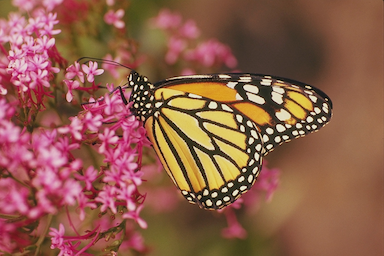

In [2]:
Butterfly = Image.open('IMGS/monarch.png')
Butterfly

Pretty, no? Cheers me up whenever I see it.....  Next we will convert this to grey-scale, so we can apply basic SIFT to it: SIFT only works with grey-scale images, though there are colour extensions to it. Previously, we have used a utility from `scikit-image` to do colour space conversion, but I have found that to sometimes fail on JPEG images.

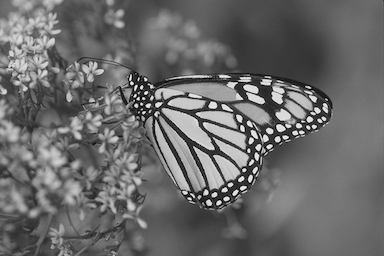

In [3]:
GreyButterfly  = ImageOps.grayscale(Butterfly) # This is using a PIL routine to map to graysacle instead
GreyButterfly

We'll immediately find the SIFT descriptors using an open source library (`PythonSIFT`) written by Russ Islam, which
seems to have been developed after the expiration of the SIFT Patent. Seems to work well from what I can discern.

In [4]:
KPs, Descriptors = computeKeypointsAndDescriptors(GreyButterfly) # Be patient... this can take a while (~1 min)!

Doubled image size to: (512, 768)
Sigma values of kernels for each octave: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
Gaussian scale space image dimensions: [(512, 768), (256, 384), (128, 192), (64, 96), (32, 48), (16, 24), (8, 12), (4, 6)]


<div style="background:#EEEEFF;color:black">

**Exercise 5.1**
Investigate the sizes and dimensions of the outputs of this command, `KPs` and `Descriptors`. You will have to make use of your knowledge of different types of data structures to do this. Record your findings and discuss them with other members of the class, and also, if desired, with the teaching associates. In particular, you want to confirm that there is a descriptor for each keypoint!

</div>

<details>
<summary> Click <b>here</b> to see the answers on this. </summary>
To see what sorts of outputs we have, we can do this:
    
`type(KPs)`
    
and we will see that the first output of the call to `computeKeypointsAndDescriptors()` is a list. To determine its length, you can use:
    
`len(KPs)`

and this is the number of keypoints produced.
    
To look at one of these keypoints, you can use (for example):
    
`KPs[0]`

and, so, doing:
    
`type(KPs[0])`

tells us the type of "thing" we have in the list. This will be found to be
an `opencvlike` keypoint.  Using `dir(KPs[0])` will tell you what attributes are associated with this object.

The basic SIFT technique only defines 4 attributes, which are keypoint location (so, two floating point numbers) the scale associated with the keypoint, and the angle associated with the keypoint. However, **opencv** also has other types of keypoint implemented, and so the **opencv** keypoint has "slots" for other things to be recorded, such as a `class id` of keypoint (a sort of type of keypoint) and a record of the octave at which the keypoint is obtained. This will be explained in class.
 
The $(x,y)$ coordinates for each keypoint are actually stored in the `.pt` attribute of the keypoint object (not particularly intuitive!).

To check the number of descriptors, we start (again) by first discovering what type of entity this is:
    
`type(Descriptors)`

and you will see that this is a `numpy` array of size $N_{kp}\times D$, where $D=128$, the "default" dimension of the SIFT descritpor.  $N_{kp}$ should be equal to the number of keypoints!
    
</details>


### 5.2 Displaying keypoints properly

Many routines for displaying the keypoints produced by SIFT get it wrong (sadly). The keypoint is not **just** a point, as characterised by the properties of location (they are in the `.pt` elements of each keypoint); there is also a scale and an orientation associated with each keypoint. There are also - in this implementation - a measure of certainty about the keypoint, how strong it is, in some sense. For now, we will just look at the keypoint size, location and angle, which is the minimum we need to get a proper intuition about what the descriptors describe, and a minimum needed to perform object recognition.

The functions for displaying the KPs are in the cell below; you just need to define the functions by running the cell.

In [62]:
def OutOfBoundsCheck(M,N,keypoint):
    OutOfBounds = False
    R = 5*1.5*keypoint.size/np.sqrt(2)
    
    if keypoint.pt[0] + R > float(N) or keypoint.pt[1] + R > float(M):
        R = min(N-keypoint.pt[0], M-keypoint.pt[1])
        OutOfBounds = True
        
    if keypoint.pt[0] < R or keypoint.pt[1] < R:
        R = min(keypoint.pt[0], keypoint.pt[1])
        OutOfBounds = True
    
    return OutOfBounds, R
    
def showKPsOnImage(image, KPs):
    # Assumes that image is a scalar image and will be displayed as such
    # This makes sense because SIFT is intended for achromatic
    # images.
    from matplotlib.patches import Circle

    [M,N] = np.shape(image)
    fig, ax = plt.subplots(figsize=(8,6))  
    ax.imshow(image, cmap='gray')
    
    # Assumes an axis has already been created which contains the
    # image that has given rise to the KP
    
    for kp in KPs:
        ax.scatter(kp.pt[0], kp.pt[1],color='r')       
    
        OutOfBounds, R = OutOfBoundsCheck(M,N,kp)
    
        if OutOfBounds:
            ax.add_patch(Circle(kp.pt, radius=R, facecolor='None', edgecolor='y', ls=':'))
        else:
            ax.add_patch(Circle(kp.pt, radius=R, facecolor='None', edgecolor='y'))
    
        # Compute vector components to be able to visualise the arrows
        u = R*np.cos((np.pi/180)*kp.angle)
        v = R*np.sin((np.pi/180)*kp.angle)
    
        # Note that quiver behaves in a rather non-linear way, so the arrows will not always agree
        # with the radius, thought directions are Ok
        ax.quiver(kp.pt[0], kp.pt[1], u, v, angles='xy', color='y', width=0.005)

Below, there is a visualisation of a random selection of 50 keypoints selected from all of those produced by the `Butterfly` image. A selection of 50 allows you to see what is going on: displaying too many at the same time makes a mess (albeit a very pretty one).

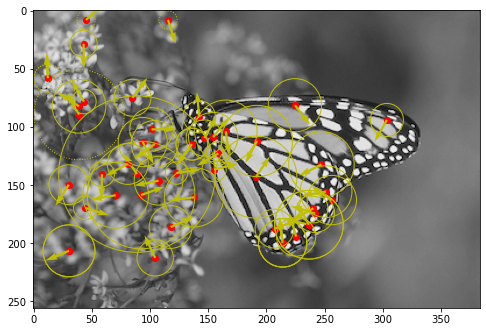

In [63]:
%matplotlib inline

# How many KPs are there?
nKPs = len(KPs)

# Increase from 50 to see more at the same time
RandomKPIndices = np.random.randint(low=0, high=nKPs, size=(50,1))

SelectedKPs = [KPs[int(selection)] for i, selection in enumerate(RandomKPIndices)] # Random sampling of the keypoints

showKPsOnImage(GreyButterfly, SelectedKPs)

For keypoints with a radius extending outside the window, the radius is actually limited, so that the region for computing the descriptor ony runs up to the bounday of the image array; keypoints with a dotted line illustrate such cases.

**Note**: it can sometimes be difficult to relate the direction of the arrows, though generally, they should provide an idea of the dominant gradient direction over the scale of the circle they lie in, essentially pointing towards the direction of increasing gradient _estimated over a region the size of the keypoint_. This can sometimes be counter-intuitive on a first glance. However, I have verified that the display technqiques used above by triggering keypoints around the boundary of a test image of a light circle against a dark background. All is well, in that the arrow directions match the expected gradient field direction (we looked at this in the Chapter 4 practical, using the code to display gradients on top of images).

### 5.3 Detecting the _presence_ of a complex object in a scene

This example was used in the original SIFT paper, and at the time, it created quite a stir in the computer vision community, as there is a large
difference in scale between the object being searched for and its appearance in the scene. First, we will load the object,
which is a box of biscotti!

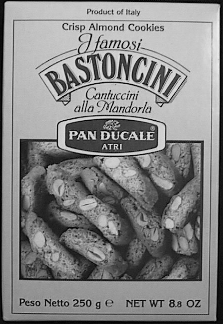

In [64]:
BoxIm = Image.open('IMGS/box.png')
BoxIm

...and this is the scene which contains the box:

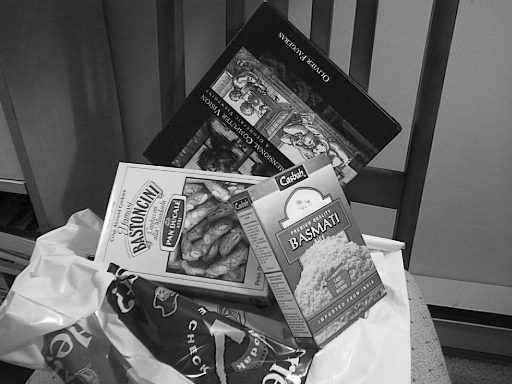

In [65]:
Scene = Image.open('IMGS/box_in_scene.png')
Scene

Our aim is to confirm the _presence_ of the biscotti box in the scene. We will not take this too
rigorously: to be rigorous, one needs to consider carefully the possibility of false matches, and do various tests to confirm
that the box is really there. Instead, we will work out how detecting distinctive descriptor matches can be achieved, and _outline_
(hint, really) at how one can go about confirming that the matches are consistent with the presence of the object in the scene.

First, we extract the keypoints and descriptors from the biscotti box ("object")....

In [66]:
ObjectKPs, ObjectDescriptors = computeKeypointsAndDescriptors(BoxIm)

Doubled image size to: (648, 446)
Sigma values of kernels for each octave: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
Gaussian scale space image dimensions: [(648, 446), (324, 223), (162, 112), (81, 56), (40, 28), (20, 14), (10, 7), (5, 4)]


In [67]:
N_objkps, D = np.shape(ObjectDescriptors)
print('Number of Object KPs is:', N_objkps)

Number of Object KPs is: 237


#### 5.3.1 Normalising Descriptors
Normalising $D$-dimensional vectors to unit length is a very common operation in machine learning. `scikit-learn` has a module to perform this, known as $L_2$ normalisation; it also support normalising in other ways, but we shall stick to $L_2$ because it permits a very easy caclulation of the cosine similarity measure, discussed in Chapter 5.

To check how this works, let's just create a couple of 4 dimensional vectors, and stick them into a $2 \times 4$ array:

In [68]:
X = np.asarray([[1,2,3,4], [10,20,30,40]], dtype=float) # refer back to Python warmup if you have forgotten what this does....
X

array([[ 1.,  2.,  3.,  4.],
       [10., 20., 30., 40.]])

Below, we normalise the rows to have unit length in the Euclidean sense; this meakes sense if _each_ row corresponds to a feature vector, and if we want to use cosine similarity to compare these two vectors against some reference vector in 4-dimensional space in a way that does not depend on the length
of the vectors, but only on direction:

In [69]:
nX = normalise(X,'l2') # That's a lower case "ell", not a 1! Dumb: should be "L2"
nX

array([[0.18257419, 0.36514837, 0.54772256, 0.73029674],
       [0.18257419, 0.36514837, 0.54772256, 0.73029674]])

And we can see that, indeed, the vectors describe identical _directions_ in 4-dimensional space. If you have difficulty understanding this, consult the lectures and notes for Chapter 5.

So, here we normalise the rows of the Object descriptors to have unit length in the Euclidean sense:

In [70]:
nObjectDescriptors = normalise(ObjectDescriptors,'l2')

#### 5.3.2 Computing descriptors for the scene
We now repeat that process for the scene....

In [71]:
# This may take up to 2 minutes to run
SceneKPs, SceneDescriptors = computeKeypointsAndDescriptors(Scene)

Doubled image size to: (768, 1024)
Sigma values of kernels for each octave: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
Gaussian scale space image dimensions: [(768, 1024), (384, 512), (192, 256), (96, 128), (48, 64), (24, 32), (12, 16), (6, 8), (3, 4)]


Below, we can check the number of descriptors; note each descriptor is of the same length, and the length of descriptors matches that of the Object keypoints; but clearly the number of keypoints does not match....

In [72]:
np.shape(SceneDescriptors)

(495, 128)

Now, we normalise the descriptors to have unit length; this will allow us to use the inner product
between descriptors as a measure of similarity.

In [73]:
# Check the documentation on sklearn.preprocessing.normalize
nSceneDescriptors = normalise(SceneDescriptors,'l2')

We now calculate a similarity matrix between the descriptors in the `Object` image and those of the scene. Each row of the matrix corresponds with one keypoint from the `Object` image; eacch column represents the cosine similarity measure against one keypoint in the `Scene` image...

In [74]:
# Voila!  The cosine similarity measure is easily computed
similarities = np.matmul(nObjectDescriptors,np.transpose(nSceneDescriptors))

Let's look at the shape of this matrix....

In [75]:
np.shape(similarities)

(237, 495)

<div class="alert alert-info">
            
You should note that the size of this simiarity matrix is equal to the number of object keypoints times the number of scene keypoints. Thus, each row represents the cosine similarity of one object descriptor to every one of the scene descriptors. Make sure you digest this fully, as it will be _very_ important in understanding what happens next.

</div>

### 5.4 Finding distinctive matches
A key trick in applying SIFT is to focus on matches of descriptors that are _distinctive_ against other candidates in the  scene. This is done by ensuring that, for each object descritor, the best matching descriptor in the scene is significantly better than the next highest matching descriptor in the scene.  This is a very important idea in the ability to use SIFT. 

In a sense, having similarity scores is not the criterion to detect a match: some descriptors in the object produce high similarity scores  with _lots_ of keypoint descriptors in the image: a colleague once described these descriptors as "promiscuous" (a bit politically incorrect, but not a bad analogy)!

Instead, we want to look for "safe" matches where the similarity of match along one row is significantly higher for one keypoint in the scene than any others.

We start by finding the top two matches for each object keypoint in the scene (read that carefully!); once this is done, we simply need to compare the largest similarity value with the next largest _in that row_, and make sure that the similarity of the largest is greater than the next largest by some margin.

In [76]:
# This sorts each row from smallest to largest, assigning it to sortedsim
sortedsim = np.sort(similarities,axis=1) # Sorts along each *row* from lowest to highest

# The top two matches for each KP in the "Object" image are the last two elements in each row.
# Again, read that sentence carefully to understand what is going on
TopTwoSceneMatchesForEachBoxKP = sortedsim[:,-3:-1]

To be very clear about what we now have: the variable `TopTwoSceneMatchesForEachBoxKP` is an $N_{objkps} \times 2$ array. The $N_{obkps}$ rows represents one row for 
each keypoint in the "`BoxIm`" (object) image (you should confirm by checking the number of original keypoints in "`BoxIm`").

In [77]:
print('Number of Object KPs:',len(ObjectKPs))
print('Number of rows in TopTwoSceneMatchesForEachBoxKP', np.shape(TopTwoSceneMatchesForEachBoxKP)[0])

Number of Object KPs: 237
Number of rows in TopTwoSceneMatchesForEachBoxKP 237


To find the _distinctive_ matches, we now want to check each row of the array `TopTwoSceneMatchesForEachBoxKP`. We want to preserve only the rows for which the top match (by the cosine similarity) is significantly larger than the next best match. We can do this by selecting the rows where the top match is greater than the second match by some factor, $\alpha$, that is greater than 1.

Experimentatlly, I have found that a good value for $\alpha$ is 1.05. This seems reasonable, given that the usual criteria is based on distance, and uses an unnormalised descriptor, with a typical factor of 1.4 between the closest  and next closest distance. Yes, this seems rather empirical, but the distribution of SIFT descriptor distances is not trivial to statistically model, so an empirical selection is fine.

In [78]:
# The factor of 1.05 may seem somewhat arbitrary; however, when using unnormalised
# SIFT matches, the recommended factor is 1.4; With L2 normalisation, experimentally it
# has been found that 1.05 gives pretty distinctive matches
alpha = 1.05
DistinctiveSceneMatchesForEachBoxKP = TopTwoSceneMatchesForEachBoxKP[:,-1]>alpha*TopTwoSceneMatchesForEachBoxKP[:,-2]

`DistinctiveSceneMatchesForEachBoxKP` is going to be a boolean array (`True` or `False`). We can use this to select the rows of the similarity matrix which meet the distinctiveness criteria; by returning to the full rows, we can find which is the best matching keypoint in the scene for each row of the distinctive matches.

In [79]:
SimilaritiesForDistinctiveRows = similarities[DistinctiveSceneMatchesForEachBoxKP,:]

In [80]:
MatchingKPIndicesInScene = np.argmax(SimilaritiesForDistinctiveRows, axis=1)
MatchingKPIndicesInScene

array([253, 102, 241, 344, 310,   5, 172,  87, 197, 169, 138, 326, 204,
       204, 201, 220, 134, 142, 112, 109, 243, 485, 128, 192, 215, 290,
       332, 194, 252])

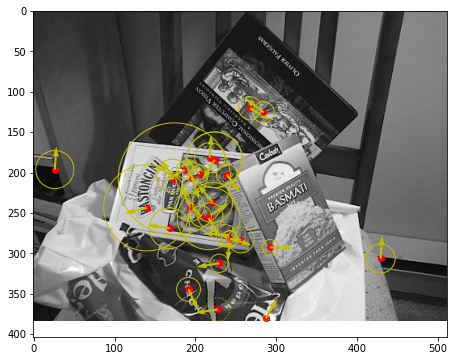

In [81]:
CandidateSceneKPs = [SceneKPs[index] for index in MatchingKPIndicesInScene]
showKPsOnImage(Scene, CandidateSceneKPs)

You will note that whilst there are many matches falling onto the correct (target) box, there are
also several points that fall outside. But we can deal with this.... 

First, we go _back_ to the "box" image and find which KPs are the ones that have distinctive "partners" in the scene:

In [82]:
CandidateObjectKPs = [ObjectKPs[index] for index,match in enumerate(DistinctiveSceneMatchesForEachBoxKP) if match==True]

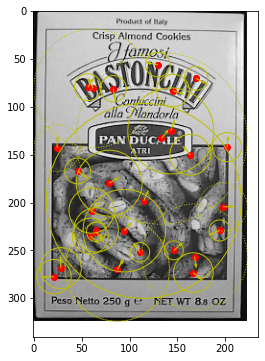

In [83]:
showKPsOnImage(BoxIm,CandidateObjectKPs)

### 5.5 Geometric Consistency of Matches

In [84]:
CandidateSceneAngles = [SceneKPs[index].angle for index in MatchingKPIndicesInScene]
CandidateObjectAngles = [ObjectKPs[index].angle for index,match in enumerate(DistinctiveSceneMatchesForEachBoxKP) if match==True]

In [85]:
deltaAngle = [(OA-SA) for OA,SA in zip(CandidateObjectAngles,CandidateSceneAngles)]

`zip` just pairs the two arrays for convenience in doing a calculation on
corresponding elements of each list; this is equivalent to a subtraction of corresponding elements that I might get if I converted both list of angles into `numpy` arrays and subtracted one from the other.

Text(0, 0.5, 'Number of KP paris')

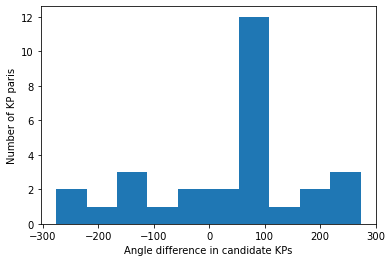

In [86]:
plt.hist(deltaAngle)
plt.xlabel('Angle difference in candidate KPs')
plt.ylabel('Number of KP paris')

We can see that the overwhelming majority of points have an angle difference of around 90 degrees. This is because the biscotti box is rotated by around 90 degrees between the "Box" image and the "Box in Scene" image!  

The voting process of a histogram can therefore be used to suggest where there is strong consistency in the angle through which a keypoint has been rotated between one image and another. In practice, you might find all peaks in a histogram, then use these in turn as possible hypotheses for the parameters of the transformation (in this case, a rotation) between the "query" image and the scene. 

A similar approach could also be taken with the `size` property associated with each keypoint: if one object contains a zooomed version of an image compared to the appearance in a template (example) image of the object, then whatever zoom factor exists between the template and the object (whether it is a zoom in or out) will be found also in the scale difference between the respective keypoints.

More generally, there are techniques that are called _geometric verification_ which take more sophisticated approaches to finding pairs of matching points which share a consistent geometric transform between one image and another. We shall not go into these in detail, but they are _very_ similar to ideas we will touch on in Chapter 6 on "Image Registration".

In [87]:
ConsistentSceneKPs = [CandidateSceneKPs[i] for i,d in enumerate(deltaAngle) if abs(d-90)<20]

And, here is what we get with the filtering of points:

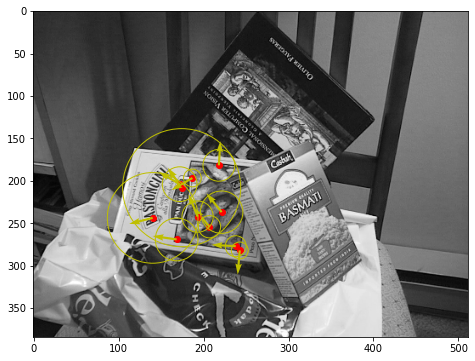

In [88]:
showKPsOnImage(Scene, ConsistentSceneKPs)

### 5.6 Learning Outcomes

In this practical, we have looked at a few key ideas that can be used for object recognition. These are:

1. Visually distinctive locations are a useful concept; I tend to think of them as "handles" that we can use to both recognise and localise objects. 

2. The SIFT descriptor produces keypoint locations and constructs descriptors for each keypoint. These descriptors are like a fingerprint of visual appearance. The keypoints and descriptors also have a reference coordinate axis provided by the location, size and angle associated to each keypoint.

3. Some descriptors can have seem to have high in a matching process, but the common nature of some fingerprints (like common words in a text search) can mean they are not reliable when searching for a particular object. The distinctiveness of a match is a good, simple filter that can remove such descriptors.

4. Keypoint angles can be used to help with finding distinctive matches, through using a sort of voting process through constructing a histogram of angle differences between the paired keypoints found through initial similarity measures. More generally, the consistency of geoemtric transformation between template keypoints and scene keypoints can be used for this purpose.